### KDE Plot for K08D

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# load in the according to the loc
weather_hist = pd.read_csv("weather_history/K08D_hist.csv",index_col=0)

# get the columns required
weather_covariates = ["temp","rhum","prcp","wdir","wspd","pres"]
weather_hist_subset = weather_hist[weather_covariates+["time"]].dropna()

# PCA decomposition of the weather data
X = weather_hist_subset[weather_covariates].values
X
# pca = PCA(n_components=X.shape[1])
# weather_hist_pca = pd.DataFrame(pca.fit_transform(X)[:,:2])
# weather_hist_pca.columns = ["pca_0","pca_1"]
# weather_hist_pca.index = pd.to_datetime(weather_hist_subset["time"])

array([[-1.0000e+00,  1.0000e+02,  0.0000e+00,  2.5000e+02,  9.4000e+00,
         1.0159e+03],
       [-4.0000e+00,  8.3000e+01,  0.0000e+00,  2.2000e+02,  7.6000e+00,
         1.0155e+03],
       [-4.0000e+00,  1.0000e+02,  0.0000e+00,  2.6000e+02,  7.6000e+00,
         1.0150e+03],
       ...,
       [ 8.0000e-01,  7.6000e+01,  0.0000e+00,  2.3300e+02,  1.3700e+01,
         1.0188e+03],
       [ 1.3000e+00,  7.7000e+01,  0.0000e+00,  2.0900e+02,  1.3000e+01,
         1.0187e+03],
       [ 2.0000e+00,  7.6000e+01,  0.0000e+00,  2.0600e+02,  1.5100e+01,
         1.0187e+03]])

In [3]:
# set data categories
weather_hist_pca["hour"] = weather_hist_pca.index.hour
weather_hist_pca["mon"] = weather_hist_pca.index.month
weather_hist_pca["hr_session"] = np.where(weather_hist_pca["hour"].between(9,21),"day","night")
weather_hist_pca["yr_half"] = np.where(weather_hist_pca["mon"]<=6,"h1","h2")
weather_hist_pca["season"] = np.where(weather_hist_pca["mon"].isin([6,7,8,9]),"summer","winter")
weather_hist_pca["time_ad"] = weather_hist_pca["season"] + "_" + weather_hist_pca["hr_session"]

Text(0.5, 1.0, '$\\mathcal{P}(weather|location=K08D,time=time\\_ad)$')

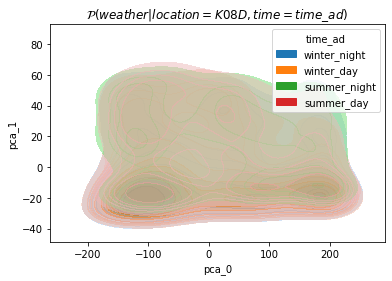

In [4]:
sns.kdeplot(
    data=weather_hist_pca, x="pca_0", y="pca_1",
    fill=True,alpha=0.5,
    hue="time_ad",bw_adjust=1)
plt.title("$\mathcal{P}(weather|location=K08D,time=time\_ad)$")

### numerical KDE 

In [5]:
vals = weather_hist_pca.loc[weather_hist_pca.time_ad=="winter_day"][["pca_0","pca_1"]]
vals.values.shape

(7592, 2)

In [6]:
from scipy.stats import gaussian_kde

In [7]:
kernel = stats.gaussian_kde(vals.values.T)

In [8]:
vals.values[0]

array([-14.69852657, -23.83432154])

In [9]:
X, Y = np.mgrid[-300:300, -100:100]
positions = np.vstack([X.ravel(), Y.ravel()])
positions.shape

(2, 120000)

In [10]:
z = kernel.evaluate(positions)
z.shape

(120000,)

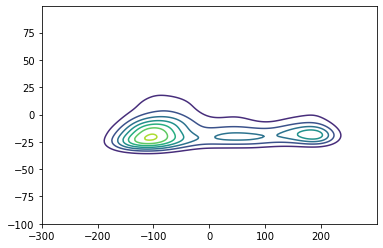

In [11]:
plt.contour(X,Y,z.reshape(X.shape))

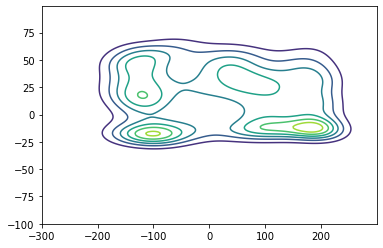

In [12]:
## summer-night contour check
vals = weather_hist_pca.loc[weather_hist_pca.time_ad=="summer_night"][["pca_0","pca_1"]]
kernel = stats.gaussian_kde(vals.values.T)

X, Y = np.mgrid[-300:300, -100:100]
positions = np.vstack([X.ravel(), Y.ravel()])

z = kernel.evaluate(positions)
plt.contour(X,Y,z.reshape(X.shape))


### function for calculating KDE 

In [13]:
time_list = ['summer_day','summer_night','winter_day','winter_night']

In [14]:
def num_kde(weather_hist_pca):
    dict_i = {}
    for status in time_list:
        vals = weather_hist_pca.loc[weather_hist_pca.time_ad==status][["pca_0","pca_1"]]
        kernel = stats.gaussian_kde(vals.values.T)
        dict_i[status] = kernel
    return dict_i

In [15]:
num_kde(weather_hist_pca)

{'summer_day': <scipy.stats._kde.gaussian_kde at 0x7fbcb9bf9e20>,
 'summer_night': <scipy.stats._kde.gaussian_kde at 0x7fbcb825a880>,
 'winter_day': <scipy.stats._kde.gaussian_kde at 0x7fbcb9d8d6d0>,
 'winter_night': <scipy.stats._kde.gaussian_kde at 0x7fbcb9bf9d60>}

In [16]:
import os
airport_list = list(map(lambda x: x.split("_")[0], os.listdir("./weather_history")))

In [23]:
def kde_calc(airport):
    dict_single ={}
    
    file ="weather_history/" + airport + "_hist.csv"
    # load in the according to the loc
    weather_hist = pd.read_csv(file,index_col=0)
    
    # get the columns required
    weather_covariates = ["temp","rhum","prcp","wdir","wspd","pres"]
    weather_hist_subset = weather_hist[weather_covariates+["time"]].dropna()
    
    # PCA decomposition of the weather data
    X = weather_hist_subset[weather_covariates].values
    pca = PCA(n_components=X.shape[1])
    weather_hist_pca = pd.DataFrame(pca.fit_transform(X)[:,:2])
    weather_hist_pca.columns = ["pca_0","pca_1"]
    weather_hist_pca.index = pd.to_datetime(weather_hist_subset["time"])
    
    weather_hist_pca["hour"] = weather_hist_pca.index.hour
    weather_hist_pca["mon"] = weather_hist_pca.index.month
    weather_hist_pca["hr_session"] = np.where(weather_hist_pca["hour"].between(9,21),"day","night")
    weather_hist_pca["yr_half"] = np.where(weather_hist_pca["mon"]<=6,"h1","h2")
    weather_hist_pca["season"] = np.where(weather_hist_pca["mon"].isin([6,7,8,9]),"summer","winter")
    weather_hist_pca["time_ad"] = weather_hist_pca["season"] + "_" + weather_hist_pca["hr_session"]
    
    #plot abd save
    sns.kdeplot(data=weather_hist_pca, x="pca_0", y="pca_1",fill=True,alpha=0.5,hue="time_ad",bw_adjust=1)
    plt.title("$\mathcal{P}(weather|location="+airport+",time=time\_ad)$")
    plt.savefig('historical_plot/plot'+airport+'.png')
    
    #calculate for kde
    dict_i = num_kde(weather_hist_pca)
    dict_single['KDE'] = dict_i
    dict_single['PCA'] = pca
    
    return dict_single

In [25]:
from tqdm.notebook import tqdm

{'KDE': {'summer_day': <scipy.stats._kde.gaussian_kde at 0x7fbcb8b9e220>,
  'summer_night': <scipy.stats._kde.gaussian_kde at 0x7fbcb8b9e340>,
  'winter_day': <scipy.stats._kde.gaussian_kde at 0x7fbcbb923940>,
  'winter_night': <scipy.stats._kde.gaussian_kde at 0x7fbcbb923b20>},
 'PCA': PCA(n_components=6)}

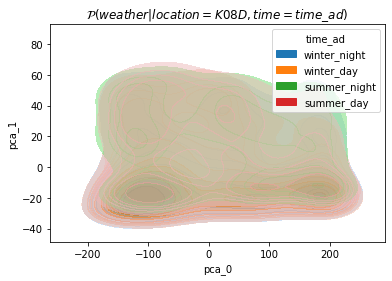

In [24]:
#kde_calc("K08D")

Error for KLBR
Error for KHMS
Error for K48I
Error for KCZK
Error for .DS
Error for KBPP
Error for K5T6
Error for K4SL
Error for K8S0
Error for K87Q
Error for KRJD
Error for KP38
Error for KU24
Error for KTDO
Error for KNHZ
Error for K3A6
Error for KMWS
Error for KRZZ
Error for KOKH
Error for KE33
Error for KMLD
Error for KVVG
Error for KU78

Total Errors 23


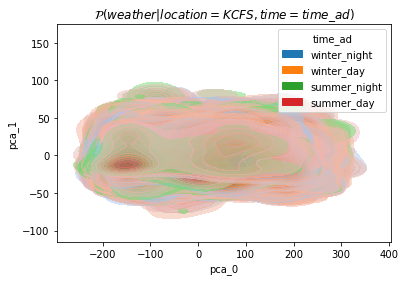

In [26]:
err_list=[]
all_airport_result = {}
for airport in tqdm(airport_list):
    try:
        dict_single = kde_calc(airport)
        all_airport_result[airport]=dict_single
    except:
        print (f"Error for {airport}")
        err_list.append(airport)
        
print ("Total Errors", len(err_list))            

In [27]:
import pickle

# a = {'hello': 'world'}

with open('kde_dict.pickle', 'wb') as handle:
    pickle.dump(all_airport_result, handle)

In [29]:
all_airport_result["KEXX"]

{'KDE': {'summer_day': <scipy.stats._kde.gaussian_kde at 0x7fbcbc275af0>,
  'summer_night': <scipy.stats._kde.gaussian_kde at 0x7fbc9ec58850>,
  'winter_day': <scipy.stats._kde.gaussian_kde at 0x7fbc9ff6fb20>,
  'winter_night': <scipy.stats._kde.gaussian_kde at 0x7fbc9ff6f3d0>},
 'PCA': PCA(n_components=6)}

In [30]:
pwd

'/Users/yibeihu/DVA project'

In [20]:
# def loop_kde(airport_list):
#     dict_single = {}
#     N = len(airport_list)
#     for i,airport in enumerate(airport_list):
#         pc = int(i*100/N)
#         if pc %5 == 0 and pc>0:
#             print (f"{pc:.0f}% airorts done")
#         dict_single[airport] = {}
#         file ="weather_history/" + airport + "_hist.csv"
#         # load in the according to the loc
#         weather_hist = pd.read_csv(file,index_col=0)

#         # get the columns required
#         weather_covariates = ["temp","rhum","prcp","wdir","wspd","pres"]
#         weather_hist_subset = weather_hist[weather_covariates+["time"]].dropna()

#         # PCA decomposition of the weather data
#         X = weather_hist_subset[weather_covariates].values
#         pca = PCA(n_components=X.shape[1])
#         weather_hist_pca = pd.DataFrame(pca.fit_transform(X)[:,:2])
#         weather_hist_pca.columns = ["pca_0","pca_1"]
#         weather_hist_pca.index = pd.to_datetime(weather_hist_subset["time"])
        
#         weather_hist_pca["hour"] = weather_hist_pca.index.hour
#         weather_hist_pca["mon"] = weather_hist_pca.index.month
#         weather_hist_pca["hr_session"] = np.where(weather_hist_pca["hour"].between(9,21),"day","night")
#         weather_hist_pca["yr_half"] = np.where(weather_hist_pca["mon"]<=6,"h1","h2")
#         weather_hist_pca["season"] = np.where(weather_hist_pca["mon"].isin([6,7,8,9]),"summer","winter")
#         weather_hist_pca["time_ad"] = weather_hist_pca["season"] + "_" + weather_hist_pca["hr_session"]
        
#         #plot abd save
#         sns.kdeplot(data=weather_hist_pca, x="pca_0", y="pca_1",fill=True,alpha=0.5,hue="time_ad",bw_adjust=1)
#         plt.title("$\mathcal{P}(weather|location="+airport+",time=time\_ad)$")
#         plt.savefig('historical_plot/plot'+airport+'.png')
    
#         #calculate for kde
#         dict_i = num_kde(weather_hist_pca)
#         dict_single[airport]['KDE'] = dict_i
#         dict_single[airport]['PCA'] = pca
#     return dict_single
    

In [21]:
file ="weather_history/" + 'K08D' + "_hist.csv"
file

'weather_history/K08D_hist.csv'